<a href="https://colab.research.google.com/github/KlaidasKaralevicius/NLP_lab2/blob/main/lab2_Klaidas_Karalevicius.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
import keras
print('Keras version:', keras.__version__)
keras.utils.set_random_seed(812)

Keras version: 3.4.1


In [ ]:
!pip install markovify -q
import markovify
print('Markovify version:', markovify.__version__)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 10.9 MB/s eta 0:00:00
Markovify version: 0.9.4


# Dainų tekstų / poezijos generavimas

Šio laboratorinio darbo metu, sukursime dviejų modelių sistemą dainų tekstų generavimui:
1. RNN (kelių sluoksnių LSTM) modelis prognozuos sekančios eilutės savybes;
2. Markovo grandinių modelis ([markovify](https://pypi.org/project/markovify/)) generuos žodžių sekas.

## 1. Duomenų atsiuntimas ir apžiūra

In [ ]:
import kagglehub

datapath = kagglehub.dataset_download("paultimothymooney/poetry")
data_files = os.listdir(datapath)
print(f'Downloaded {len(data_files)} files:', data_files)

100%|██████████| 2.00M/2.00M [00:00<00:00, 91.1MB/s]

Extracting files...
Downloaded 49 files: ['missy-elliott.txt', 'ludacris.txt', 'notorious_big.txt', 'nicki-minaj.txt', 'radiohead.txt', 'janisjoplin.txt', 'bruno-mars.txt', 'Kanye_West.txt', 'nirvana.txt', 'michael-jackson.txt', 'amy-winehouse.txt', 'adele.txt', 'dj-khaled.txt', 'lady-gaga.txt', 'bruce-springsteen.txt', 'beatles.txt', 'Lil_Wayne.txt', 'lil-wayne.txt', 'britney-spears.txt', 'bob-marley.txt', 'bjork.txt', 'bob-dylan.txt', 'r-kelly.txt', 'jimi-hendrix.txt', 'kanye.txt', 'prince.txt', 'eminem.txt', 'alicia-keys.txt', 'rihanna.txt', 'notorious-big.txt', 'dolly-parton.txt', 'johnny-cash.txt', 'cake.txt', 'al-green.txt', 'dickinson.txt', 'disney.txt', 'nickelback.txt', 'lorde.txt', 'leonard-cohen.txt', 'dr-seuss.txt', 'blink-182.txt', 'bieber.txt', 'drake.txt', 'joni-mitchell.txt', 'lin-manuel-miranda.txt', 'paul-simon.txt', 'patti-smith.txt', 'nursery_rhymes.txt', 'kanye-west.txt']


In [ ]:
characters_counts = {}
for data_file in data_files:
  with open(os.path.join(datapath, data_file), 'r') as f:
    characters_counts[data_file] = len(f.read())

total = sum(list(characters_counts.values()))
print(f'Total characters: {total}')
for k, v in characters_counts.items():
  print(f'- {k}: {v} characters ({v / total * 100 :.2f} %)')

Total characters: 6730841
- missy-elliott.txt: 191833 characters (2.85 %)
- ludacris.txt: 237218 characters (3.52 %)
- notorious_big.txt: 228694 characters (3.40 %)
- nicki-minaj.txt: 210135 characters (3.12 %)
- radiohead.txt: 58829 characters (0.87 %)
- janisjoplin.txt: 106182 characters (1.58 %)
- bruno-mars.txt: 131415 characters (1.95 %)
- Kanye_West.txt: 251069 characters (3.73 %)
- nirvana.txt: 60753 characters (0.90 %)
- michael-jackson.txt: 251022 characters (3.73 %)
- amy-winehouse.txt: 76363 characters (1.13 %)
- adele.txt: 91330 characters (1.36 %)
- dj-khaled.txt: 238318 characters (3.54 %)
- lady-gaga.txt: 147050 characters (2.18 %)
- bruce-springsteen.txt: 107497 characters (1.60 %)
- beatles.txt: 70685 characters (1.05 %)
- Lil_Wayne.txt: 114135 characters (1.70 %)
- lil-wayne.txt: 114134 characters (1.70 %)
- britney-spears.txt: 135287 characters (2.01 %)
- bob-marley.txt: 91527 characters (1.36 %)
- bjork.txt: 53217 characters (0.79 %)
- bob-dylan.txt: 196797 characte

In [ ]:
artist_file = 'michael-jackson.txt'
with open(os.path.join(datapath, artist_file), 'r') as f:
    print(f.read(500))



[Spoken Intro:]
You ever want something 
that you know you shouldn't have 
The more you know you shouldn't have it, 
The more you want it 
And then one day you get it, 
It's so good too 
But it's just like my girl 
When she's around me 
I just feel so good, so good 
But right now I just feel cold, so cold 
Right down to my bones 
'Cause ooh... 
Ain't no sunshine when she's gone 
It's not warm when she's away 
Ain't no sunshine when she's gone 
And she's always gone too long 
Anytime she goes a


### Paruošimas modelio apmokymui: teksto normalizavimas

Dainų tekstai gali turėti skaičius, bet mums reikia konvertuoti juos į žodžius, kad galėtumėme vėliau teisingai rimuoti. Tam naudosime `num2words` paketą. Jų yra ir kitų.

In [ ]:
!pip install num2words -q
from num2words import num2words

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 6.8 MB/s eta 0:00:00


In [ ]:
num2words(23)

'twenty-three'

Galime naudoti standartinius normalizavimo metodus, pavyzdžiui, sumažinti visas raides ir pašalinti skyrybos ženklus, tačiau turėtume palikti trumpinius, nes jie turi skirtingą nuo pilnų versijų ritmą ir kitaip rimuojasi.

In [ ]:
def normalize_word_line(line: str) -> list[str]:
  row = [x.lower() for x in re.findall(r"\w+'?\w*", line)]
  new_row = []
  for word in row:
    numbers = re.findall(r"\d+", word)
    for n in numbers:
      word = word.replace(n, num2words(int(n)))
    new_row.append(word)
  return new_row

In [ ]:
normalize_word_line("I got 99 problems but NLP ain't one")

['i', 'got', 'ninety-nine', 'problems', 'but', 'nlp', "ain't", 'one']

Panaudojame normalizavimą Nirvana tekstams, galime pažiūrėti kokie žodžiai yra dažniausi:

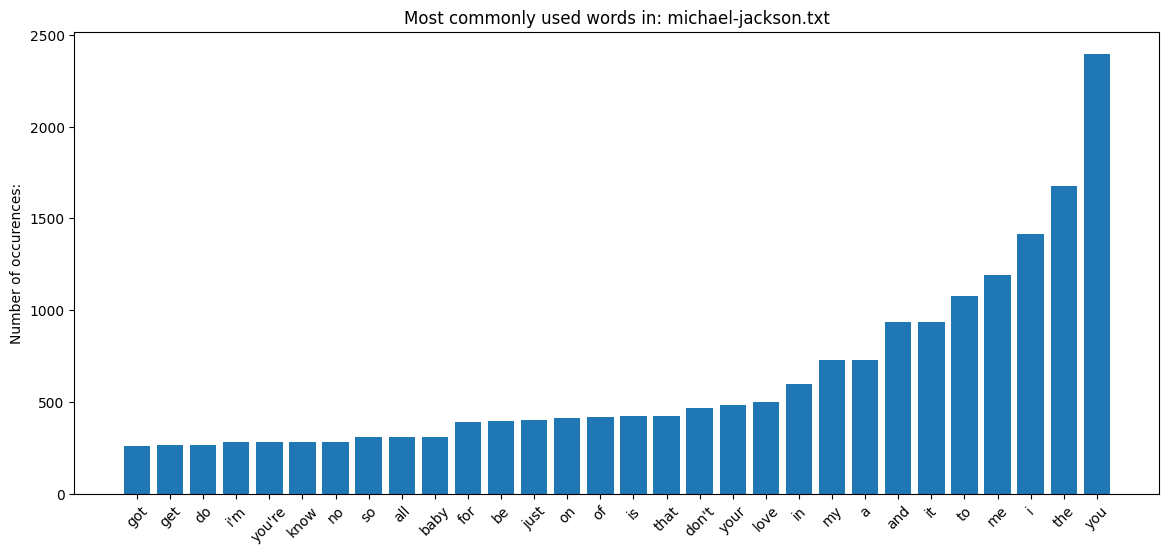

In [ ]:
with open(os.path.join(datapath, artist_file), 'r') as f:
    words = normalize_word_line(f.read())

words_u, words_c = np.unique(words, return_counts=True)
sorted_by_counts = sorted([(u, c) for u, c in zip(words_u, words_c)], key=lambda x: x[1])

n_to_plot = 30
common_words = [x[0] for x in sorted_by_counts[-n_to_plot:]]
common_counts = [int(x[1]) for x in sorted_by_counts[-n_to_plot:]]

plt.figure(figsize=(14, 6))
plt.bar(x=common_words, height=common_counts)
plt.xticks(rotation=45)
plt.ylabel('Number of occurences:')
plt.title(f'Most commonly used words in: {artist_file}')
plt.show()

## 2. Markovo grandinių modelio inicializavimas

Galime sukurti paprastą Markovo grandinių modelį Nirvana grupės žodžiams.
- Sekantis žodis yra pasirenkamas naudojant sukonstruotą Markovo grandinę ir atitinkamas tikimybes.

In [ ]:
with open(os.path.join(datapath, artist_file), 'r') as f:
  lyrics = f.read()

# Random seed neužfiksuotas, todėl visi gausite skirtingus rezultatus
markov_model = markovify.NewlineText(lyrics)

for i in range(5):
    print(markov_model.make_sentence())

Oh oh Hollywood it’s got you drunk enough to fall
But if it seems so hard to live...
Sometimes I can be so proud if you just scream and shout it
Tell me what has become of my hand and we kissed in the village
And I can feel the glow of candlelight


Sakiniai atrodo turi kažkokią prasmę, tačiau nėra ritmo, ir eilutės nėra rimuotos.

Galime apmokyti RNN modelį, kuris kontroliuos eilėraščio struktūrą.

##3. Ritmo ištraukimas iš duomenų

Paskaičiuojame skiemenų kiekius:

In [ ]:
def n_syllables(word_line: list[str]):
    vowels = 'aeiouy'
    syllable_count = 0

    for word in word_line:
        for i, char in enumerate(word):
            if char in vowels:
                if (i == 0) or (word[i-1] not in vowels):
                    syllable_count += 1
        word_vowels_count = sum([x in vowels for x in word])
        if word_vowels_count == 0:  # abreviaturos
            syllable_count = len(word)  # pvz. "NLP" skaitosi kaip "en-el-pi"
        elif word_vowels_count > 1 and (word[-1] == 'e') and (word[-2] not in vowels):  # paskutinė "e" dažnai nesakoma anglų k., bet "ie", "ee" ištariama
            syllable_count -= 1

    return syllable_count

In [ ]:
with open(os.path.join(datapath, artist_file), 'r') as f:
  lyrics = f.read()
sentence = normalize_word_line(lyrics.splitlines()[10])
print(sentence)
print(f'N syllables: {n_syllables(sentence)}')

['when', "she's", 'around', 'me']
N syllables: 5


Eilėraščiuose paskutini žodžiai dažniausiai rimuojasi. Tam naudosime [pronouncing](https://pypi.org/project/pronouncing/) paketą:

In [ ]:
!pip install pronouncing -q
import pronouncing
print('Pronouncing version:', pronouncing.__version__)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 17.1 MB/s eta 0:00:00
Pronouncing version: 0.2.0


10 žodžių kurie rimuojasi su žodžiu "nirvana":

In [ ]:
np.random.choice(pronouncing.rhymes("around"), size=10)

array(['confound', 'hound', 'unsound', 'renowned', 'surround', 'wound',
       'bound', 'lb', 'mound', "'round"], dtype='<U10')

Tačiau mes nenorime naudoti bele kokius žodžius, o norime prioretizuoti žodžius iš jau esamų atlikėjo dainų. Todėl reikia sukonstruoti rimuojančių žodžių žodyną.

In [ ]:
def get_rhyme(line: list[str]) -> str:
    last_word = re.sub('\W+', '', line[-1])
    all_rhymes = pronouncing.rhymes(last_word)
    if all_rhymes:
        rhyming_ends = [x[-2:] for x in all_rhymes]
        most_common_rhyme = max(set(rhyming_ends), key=rhyming_ends.count)
    else:
        most_common_rhyme = last_word[-2:]
    return most_common_rhyme


def get_rhyme_list(normalized_lyrics: list[list[str]]):
  rhyme_set = set()
  for row in normalized_lyrics:
    most_common_rhyme = get_rhyme(row)
    rhyme_set.add(most_common_rhyme)

  sorted_rhyme_set = sorted(list(rhyme_set), key=lambda x: x[-1])
  return sorted_rhyme_set


with open(os.path.join(datapath, artist_file), 'r') as f:
  lyrics = f.read()
lyrics = [normalize_word_line(x) for x in lyrics.splitlines()]
lyrics = [x for x in lyrics if x]
rhymes = get_rhyme_list(lyrics)
print(f'Collected {len(rhymes)} rhymes')

Collected 184 rhymes


In [ ]:
rhymes[:10]

["s'", 'ia', 'a', 'ea', 'sa', 'da', 'ra', 'ma', 'ta', 'aa']

Dabar galime pridėti skiemenų kiekio ir rimuojančių žodžių skaičiavimus kaip sugeneruotų eilučių savybes.

## 4. Duomenų rinkinio paruošimas

Modelis negalės tiesiogiai operuoti skiemenimis, todėl turime naudoti skaičius:

In [ ]:
def get_rhyme_float(line: list[str], rhyme_list: list[str]) -> float | None:
  rhyme = get_rhyme(line)
  if rhyme in rhyme_list:
    return rhyme_list.index(rhyme) / len(rhyme_list)
  else:
    return None


test = [markov_model.make_sentence() for _ in range(5)]
for line in test:
  rhyme_float = get_rhyme_float(normalize_word_line(line), rhymes)
  print(f'Rhyme float: {rhyme_float:.2f} \tLine:', line)

Rhyme float: 0.72 	Line: Coming at ya rather too fast for us
Rhyme float: 0.78 	Line: Feel the vibe cause I just couldn't believe it
Rhyme float: 0.52 	Line: The Way You Shake Your Body Won't You G'on Down
Rhyme float: 0.70 	Line: When This Is Injustice
Rhyme float: 0.48 	Line: He wanna wrap his arms all around and now my money's gone


In [ ]:
def get_random_lines(markov_model, n_rows: int) -> list[list[str]]:
  lines = []
  last_words = []

  while len(lines) < n_rows:
    line = markov_model.make_sentence(max_overlap_ratio=.49, tries=100)
    # nenorime gauti tuščios eilutės ar jau turimos eilutės
    if (line is not None) and (line not in lines):
      last_word = normalize_word_line(line)[-1]
      # nenorime kad dažnai pasikartotų tas pats žodis eilutės gale
      if last_words.count(last_word) < 3:
        lines.append(normalize_word_line(line))
        last_words.append(last_word)

  return lines


def get_line_features(line: list[str], rhyme_list: list[str]) -> tuple:
  return (line, n_syllables(line), get_rhyme_float(line, rhyme_list)) # n_syllables(line) turi buti float ne int


test_lines = get_random_lines(markov_model, 2)
for line in test_lines:
  print(get_line_features(line, rhymes))

(['she', 'said', 'i', 'have', 'to', 'tell', 'him', 'what', 'you', 'want'], 10, 0.75)
(["we've", 'got', 'rainbows', 'yet', 'to', 'find', 'the', 'right', 'to', 'shake', 'my', 'family'], 15, 0.8804347826086957)


Konstruojame duomenų rinkinį:

In [ ]:
def build_dataset(lines: list[list[str]], rhyme_list: list[str]):
	features = [get_line_features(x, rhyme_list) for x in lines]
	x_data, y_data = [], []

  # turėsime standartinę struktūrą kai eilutės rimuojasi po 4 grupėje
	# pirmos dvi eilutės bus pradinės savybės, antros dvi eilutės - prognozuojamos
	for i in range(len(features) - 3):
		# duomenyse liks tik eilučių savybes, todėl visur [1:]
		line1, line2 = features[i    ][1:], features[i + 1][1:]
		line3, line4 = features[i + 2][1:], features[i + 3][1:]
		x_data.append(np.array([line1, line2]))
		y_data.append(np.array([line3, line4]))
	return np.array(x_data), np.array(y_data)


dataset = build_dataset(lyrics, rhymes)
len(dataset[0]), len(dataset[1])

(9481, 9481)

In [ ]:
# pirmo mėginio pvz.
dataset[0][0], dataset[1][0]

(array([[4.        , 0.55434783],
        [7.        , 0.27717391]]),
 array([[6.        , 0.19021739],
        [8.        , 0.77717391]]))

## 5. RNN modelio inicializavimas

Mūsų modelis turės prognozuoti naujų 4 eilučių savybes gaunant senas 4 eilutes.

In [ ]:
def create_lstm(depth: int):

  keras.backend.clear_session()  # pašaliname tarpinių modelių likučius
  keras.utils.set_random_seed(812)

  model = keras.Sequential(name='LSTM-based_lyrics_generator')
  model.add(keras.layers.Input((2, 2)))
  model.add(keras.layers.LSTM(4, return_sequences=True))
  for i in range(depth):
    model.add(keras.layers.LSTM(8, return_sequences=True)) # LSTM keisti GRU
  model.add(keras.layers.LSTM(2, return_sequences=True))

  model.compile(
      optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
      loss='mse')

  return model

model = create_lstm(depth=1)
model.summary()

Model: "LSTM-based_lyrics_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 2, 4)                │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 2, 8)                │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 2, 2)                │              88 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 616 (2.41 KB)

 Trainable params: 616 (2.41 KB)

 Non-trainable params: 0 (0.00 B)

Turime **dviejų modelių sistemą**, todėl būtina parašyti funkcijas kad modeliai galėtų tarpusavyje bendrauti.

In [ ]:
def compose(starting_input: np.ndarray, rnn_model, n_line_groups: int):
	prev_vectors = starting_input
	final_vectors = []
	for i in range(n_line_groups):
		final_vectors.append(rnn_model.predict(prev_vectors).flatten().reshape(1, 2, 2))
		prev_vectors = final_vectors[-1]
	return final_vectors


def last_word_compare(prev_lines: list[list[str]], new_line: list[str], penalty: float = 0.2) -> float:
	sum_penalty = 0.0
	for line in prev_lines:
		if line[-1] == new_line[-1]:
			sum_penalty += penalty
	return sum_penalty


def calculate_score(features, n_syllables, rhyme, penalty: float, rhyme_list, maxsyllables):
	desired_n_syllables = features[0] * maxsyllables
	desired_rhyme = features[1] * len(rhyme_list)
	syllable_score = - abs(float(desired_n_syllables) - float(n_syllables))
	rhyme_score = abs(float(desired_rhyme) - float(rhyme))
	score = 1.0 + syllable_score + rhyme_score - penalty
	return score


def vectors_into_song(vectors, generated_lyrics, rhyme_list, maxsyllables: int):
	song = []
	generated_features = [get_line_features(x, rhyme_list) for x in generated_lyrics]

	vector_halves = []
	for vector in vectors:
		vector_halves.extend(vector[0].tolist())

	for vector in vector_halves:
		scorelist = []

		for (line, n_syllables, rhyme) in generated_features:
			if len(song) != 0:
				penalty = last_word_compare(song, line)
			else:
				penalty = 0

			total_score = calculate_score(vector, n_syllables, rhyme, penalty, rhyme_list, maxsyllables)
			scorelist.append([line, total_score])

		# randame eilutę su aukščiausiu įvertinimu
		best_line_index = np.argmax([float(x[1]) for x in scorelist])
		best_line = scorelist[best_line_index][0]
		song.append(best_line)

		# pašaliname šią eilutę iš likusių eilučių sąrašo
		generated_features = [x for x in generated_features if x[0] != best_line]

	return [' '.join(x) for x in song]

# kokie žodžiai bus sugeneruoti be modelio apmokymo?
start = np.array([dataset[0][0]])
vectors = compose(start, model, 4)
some_lyrics = get_random_lines(markov_model, 20)
vectors_into_song(vectors, some_lyrics, rhymes, maxsyllables=12)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


["when you're out of your brother in jail",
 'and now you do it for our children',
 "i've been around the world in one day",
 "that girl i can't believe it you know it",
 'all i know that i must be out of school',
 'everywhere you seem to get up and see',
 "i know you'll be there yeah i will love you better",
 'now i believe you and it was love and romance']

## 6. Modelio apmokymas

In [ ]:
x_data, y_data = dataset

model.fit(
    x_data, y_data,
    batch_size=2,
    epochs=2
)

Epoch 1/2
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 20.2757
Epoch 2/2
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 19.8891


In [ ]:
# kokie žodžiai bus sugeneruoti po modelio apmokymo?
start = np.array([dataset[0][0]])
vectors = compose(start, model, 4)
some_lyrics = get_random_lines(markov_model, 20)
vectors_into_song(vectors, some_lyrics, rhymes, maxsyllables=12)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


['how does it seem like you to take me',
 'that you said we were looking for the movie screen',
 "we'd live a love that makes me want",
 "in despair we'll be a part of the disco tech",
 'as you live in your soul like a sparrow',
 'you see i never let you down like a sparrow',
 'let them all in the back',
 "i'm gonna have to say you wouldn't do it like spit"]

Sudedame viską į vientą vietą:

In [ ]:
artist_file = 'notorious-big.txt'
with open(os.path.join(datapath, artist_file), 'r') as f:
    raw_lyrics = f.read()

markov_model = markovify.NewlineText(raw_lyrics)

lyrics = [normalize_word_line(x) for x in raw_lyrics.splitlines()]
lyrics = [x for x in lyrics if x]
rhymes = get_rhyme_list(lyrics)
print(f'Collected {len(rhymes)} rhymes')

x_data, y_data = build_dataset(lyrics, rhymes)

model = create_lstm(depth=4)
print(model.summary())

model.fit(
    x_data, y_data,
    batch_size=2,
    epochs=10
)

start_i = np.random.choice(range(len(x_data)))
start = np.array([x_data[start_i]])
vectors = compose(start, model, 4)
some_lyrics = get_random_lines(markov_model, 200)
vectors_into_song(vectors, some_lyrics, rhymes, maxsyllables=12)

Collected 206 rhymes


Model: "LSTM-based_lyrics_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 2, 4)                │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 2, 8)                │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 2, 8)                │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 2, 8)                │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 2, 8)                │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 2, 2)                │              88 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,248 (8.78 KB)

 Trainable params: 2,248 (8.78 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
2640/2640 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 61.1819
Epoch 2/10
2640/2640 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 59.0713
Epoch 3/10
2640/2640 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 59.0712
Epoch 4/10
2640/2640 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 59.0712
Epoch 5/10
2640/2640 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 59.0712
Epoch 6/10
2640/2640 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 59.0712
Epoch 7/10
2640/2640 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 59.0712
Epoch 8/10
2640/2640 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 59.0712
Epoch 9/10
2640/2640 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 59.0712
Epoch 10/10
2640/2640 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 59.0712
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


['silly cat all suede in the mornin kick the war but they be mackin but they grabbed the nixga play pussy thats the nixga jd i was high when they stacks right',
 'cause im a bad bad boy what you want nixga',
 'going around the world fuck my friend bitch',
 'but of course you know how i bring gun drama',
 'sure do two s in your chains and your chaperon',
 'gonja sensamelia can i do is touch ya',
 'blows was thrown and a bag to put the g in game had the slow grooves on',
 'wake up wake your ass kizzack i dont give a fuck']